# Time-series forecast of Temperature using Keras LSTM

In [1]:
# We study the data set of the historical hourly weather data 2012-2017 
# from kaggle.com. The link is provided as follows:
# https://www.kaggle.com/selfishgene/historical-hourly-weather-data
#
# We study the time-series of temperature for New York city.
# The first part is devoted to studying the temperature forecast of 
# time-series by using LSTM. The forecast period is 24 hours.
# 
# The second part is to examine the multi-variate forecast of time-series
# by using  LSTM. We incorporate the time series of temperature, pressure,
# humidity and wind speed to predict the temperature.
#
# The two methods do not show significant in predicting the temperature.
#

# Univariate Time-series prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
df=pd.read_csv("temperature.csv")

In [4]:
df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


In [5]:
df['datetime']=pd.to_datetime(df['datetime'])

In [6]:
df=df.set_index('datetime')

In [7]:
df[['New York']].head()

,New York
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,288.220000
2012-10-01 14:00:00,288.247676
2012-10-01 15:00:00,288.326940
2012-10-01 16:00:00,288.406203


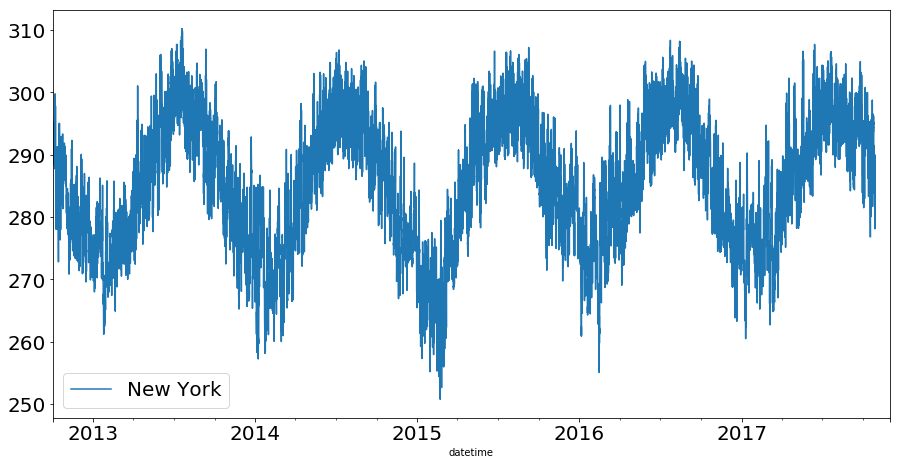

In [8]:
ax = df[['New York']].plot(figsize=(15,7.5),fontsize=20)
ax.legend(['New York'], fontsize = 20)

In [9]:
df1=df[['New York']]

In [10]:
df1=df1.dropna()

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44460 entries, 2012-10-01 13:00:00 to 2017-10-28 00:00:00
Data columns (total 1 columns):
New York    44460 non-null float64
dtypes: float64(1)
memory usage: 694.7 KB


In [12]:
# The difference operation to make the time-series stationary

In [13]:
df1=df1.diff(periods=1)
df1=df1.dropna()

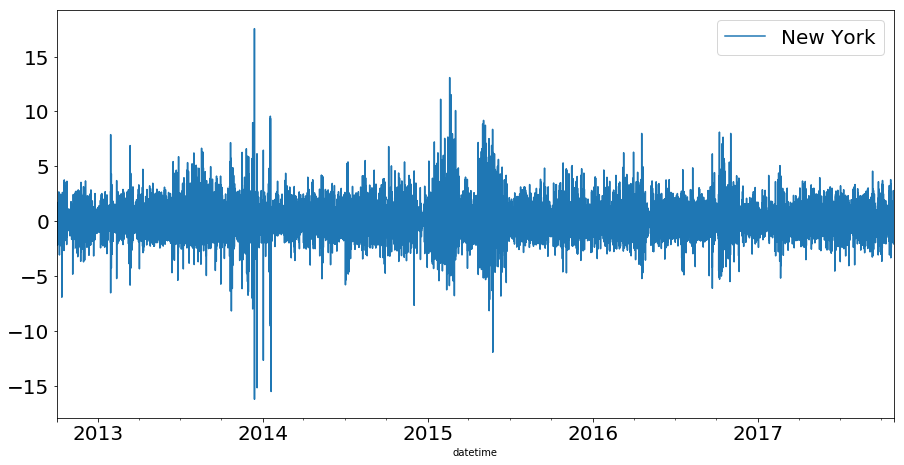

In [14]:
ax = df1.plot(figsize=(15,7.5),fontsize=20)
ax.legend(['New York'], fontsize = 20)

In [15]:
# Autocorrelation
print(df1.iloc[:,0].autocorr(lag=24))

0.4855353967903293


In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\HoT\Anaconda3_2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
freq=2
result=seasonal_decompose(df1,freq=freq)

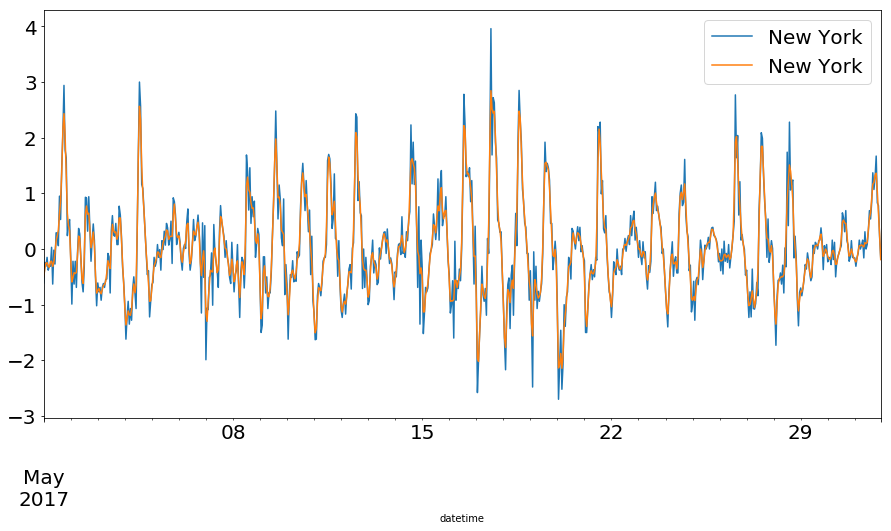

In [18]:
ax = result.trend['2017-05'].plot(ax=df1['2017-05'].plot(),figsize=(15,7.5),fontsize=20)
ax.legend(fontsize=20)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
# Mean squared error beteen the original data and the trend
print(mean_squared_error(df1.iloc[1:-1,0],result.trend.dropna()))

0.24581589508658278


In [21]:
# Autocorrelation: 
# autocorrelation of trend is much higher than the original data
print(result.trend.dropna().iloc[:,0].autocorr(lag=24))

0.6477243781872428


In [22]:
# Scale the amplitude of time series between 0 and 1.

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [24]:
scaled=scaler.fit_transform(result.trend.dropna().values.reshape(-1,1).astype('float32'))

In [25]:
# Function for splitting train and test sets
def train_test_split(data,split=.7):
    train_size = int(len(data)*split)
    train = data[0:train_size]
    test = data[train_size:]
    return train, test

In [26]:
split = .7
train, test = train_test_split(scaled, split)

In [27]:
# Function for producing input and output data
def create_dataset(data,lookback=1):
    dataX=data[:len(data)-lookback]
    dataY=data[lookback:].flatten()
    return dataX,dataY

In [28]:
# Forecast period is 24 hr
look_back = 24
train_X, train_y = create_dataset(train, look_back)
test_X, test_y = create_dataset(test, look_back)

In [29]:
train_X=train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X=test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

C:\Users\HoT\Anaconda3_2\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [31]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5)

In [32]:
# Model

In [33]:
model = Sequential()
model.add(LSTM(50,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.05))
model.add(LSTM(100))
model.add(Dropout(0.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(25, activation='tanh'))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
__________

In [34]:
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=1, callbacks = [early_stopping_monitor], shuffle=False)

Train on 31095 samples, validate on 13314 samples
Epoch 1/100
31095/31095 [==============================] - 3s 90us/step - loss: 0.0113 - val_loss: 0.0019
Epoch 2/100
31095/31095 [==============================] - 2s 49us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/100
31095/31095 [==============================] - 2s 48us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 4/100
31095/31095 [==============================] - 2s 51us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 5/100
31095/31095 [==============================] - 2s 49us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/100
31095/31095 [==============================] - 2s 48us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 7/100
31095/31095 [==============================] - 1s 48us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 8/100
31095/31095 [==============================] - 2s 48us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 9/100
31095/31095 [==============================] - 2s 49us/step - loss: 0.0019 - val_loss: 0.0

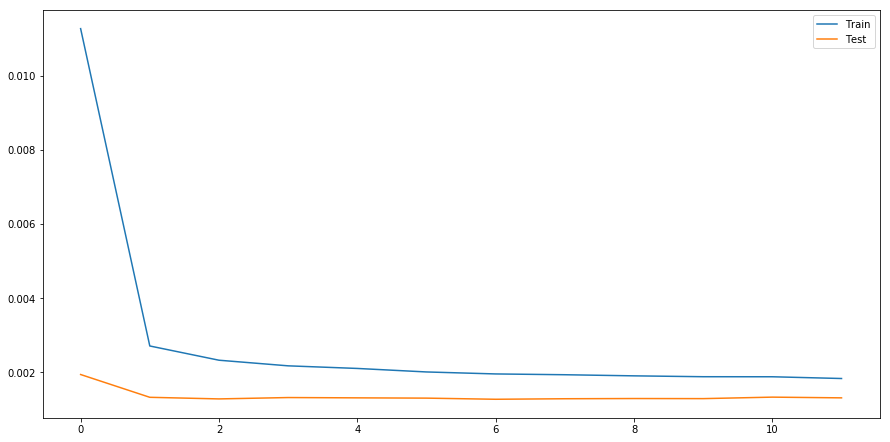

In [35]:
# Plot for train and test losses
plt.figure(figsize=(15,7.5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.rc('font', size=10)

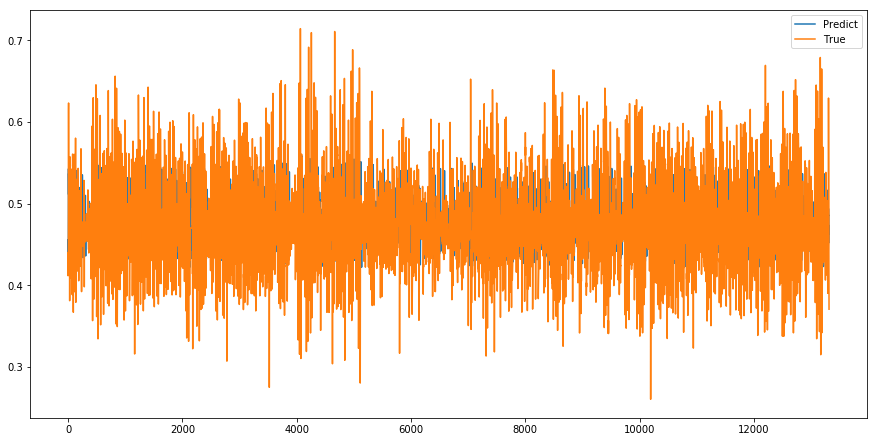

In [36]:
# Compare the test set and prediction set
testPredict = model.predict(test_X)
plt.figure(figsize=(15,7.5))
plt.plot(testPredict, label='Predict')
plt.plot(test_y, label='True')
plt.legend()
plt.rc('font', size=10)

In [37]:
trainPredict=model.predict(train_X)

In [38]:
# Rescale the data set

In [39]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [40]:
train_y = scaler.inverse_transform([train_y])
test_y = scaler.inverse_transform([test_y])

In [41]:
rmse = np.sqrt(mean_squared_error(train_y[0], trainPredict[:,0]))
print('Train RMSE: {}'.format(rmse))

Train RMSE: 0.6693700522347533


In [42]:
rmse = np.sqrt(mean_squared_error(test_y[0], testPredict[:,0]))
print('Test RMSE: {}'.format(rmse))

Test RMSE: 0.6003006977634153


In [43]:
# Compare with the original data

In [44]:
split = .7
dtrain, dtest = train_test_split(df1.iloc[1:-1,0].values,split)

In [45]:
# Forecast period is 24 hr
look_back = 24
dtrain_X, dtrain_y = create_dataset(dtrain, look_back)
dtest_X, dtest_y = create_dataset(dtest, look_back)

In [46]:
rmse = np.sqrt(mean_squared_error(dtrain_y, trainPredict[:,0]))
print('Actual Train RMSE: {}'.format(rmse))

Actual Train RMSE: 0.9657725298432989


In [47]:
rmse = np.sqrt(mean_squared_error(dtest_y, testPredict[:,0]))
print('Actual Test RMSE: {}'.format(rmse))

Actual Test RMSE: 0.7540816941535651


# Multi-variate LSTM

In [48]:
# We load the different data sets: temperature, humidity, pressure and wind speed.

In [49]:
dft=pd.read_csv("temperature.csv")
dfh=pd.read_csv("humidity.csv")
dfp=pd.read_csv("pressure.csv")
dfw=pd.read_csv("wind_speed.csv")

In [50]:
dft['datetime']=pd.to_datetime(dft['datetime'])
dfh['datetime']=pd.to_datetime(dfh['datetime'])
dfp['datetime']=pd.to_datetime(dfp['datetime'])
dfw['datetime']=pd.to_datetime(dfw['datetime'])

In [51]:
dft=dft.set_index('datetime')
dfh=dfh.set_index('datetime')
dfp=dfp.set_index('datetime')
dfw=dfw.set_index('datetime')

In [52]:
dft1 = dft[['New York']]
dfh1 = dfh[['New York']]
dfp1 = dfp[['New York']]
dfw1 = dfw[['New York']]

In [53]:
dft1.columns = ['Temperature']
dfp1.columns = ['Pressure']
dfh1.columns = ['Humidity']
dfw1.columns = ['Wind_Speed']

In [54]:
dft1=dft1.diff(periods=1)
dfp1=dfp1.diff(periods=1)
dfw1=dfw1.diff(periods=1)
dfh1=dfh1.diff(periods=1)

In [55]:
dft1 = dft1.fillna(method='ffill')
dfp1 = dfp1.fillna(method='ffill')
dfw1 = dfw1.fillna(method='ffill')
dfh1 = dfh1.fillna(method='ffill')

In [56]:
all_result0 = pd.concat([dft1,dfp1,dfw1,dfh1],axis=1)
all_result0 = all_result0.dropna()

In [57]:
all_result0['STemperature'] = all_result0[['Temperature']].shift(-24)

In [58]:
freq=2
all_result = pd.concat([seasonal_decompose(all_result0[[all_result0.columns[0]]],freq=freq).trend,
                       seasonal_decompose(all_result0[[all_result0.columns[1]]],freq=freq).trend,
                       seasonal_decompose(all_result0[[all_result0.columns[2]]],freq=freq).trend,
                       seasonal_decompose(all_result0[[all_result0.columns[3]]],freq=freq).trend,
                       seasonal_decompose(all_result0[[all_result0.columns[0]]],freq=freq).trend.shift(-24)],axis=1)

In [59]:
all_result = all_result.dropna()

In [60]:
scaled=scaler.fit_transform(all_result.values)

In [61]:
split = .7
train_size=int(len(scaled)*split)
test_size=len(scaled)-train_size

In [62]:
train=scaled[:train_size,:]
test=scaled[train_size:,:]

In [63]:
train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]

In [64]:
train_X=train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
test_X=test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [65]:
# Model: using LSTM

In [66]:
model = Sequential()
model.add(LSTM(50,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.05))
model.add(LSTM(100))
model.add(Dropout(0.05))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(25, activation='tanh'))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 50)             11000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
__________

In [67]:
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=1, callbacks = [early_stopping_monitor], shuffle=False)

Train on 31657 samples, validate on 13568 samples
Epoch 1/100
31657/31657 [==============================] - 3s 96us/step - loss: 0.0105 - val_loss: 0.0021
Epoch 2/100
31657/31657 [==============================] - 2s 49us/step - loss: 0.0026 - val_loss: 0.0014
Epoch 3/100
31657/31657 [==============================] - 2s 49us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 4/100
31657/31657 [==============================] - 2s 49us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 5/100
31657/31657 [==============================] - 2s 49us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/100
31657/31657 [==============================] - 2s 49us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 7/100
31657/31657 [==============================] - 2s 50us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 8/100
31657/31657 [==============================] - 2s 50us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 9/100
31657/31657 [==============================] - 2s 52us/step - loss: 0.0019 - val_loss: 0.0

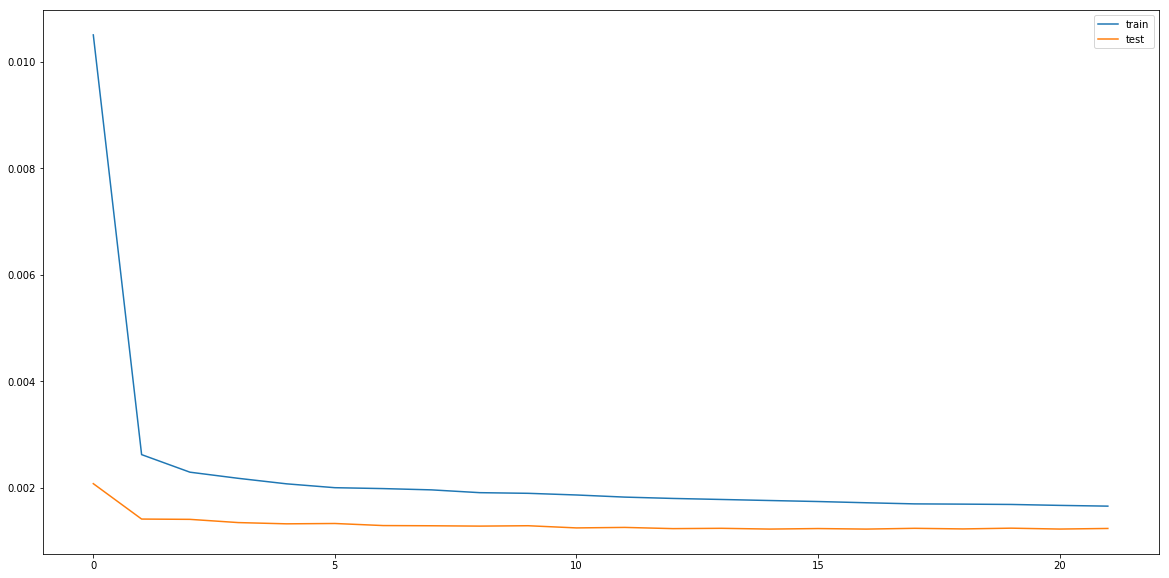

In [68]:
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.rc('font', size=20)

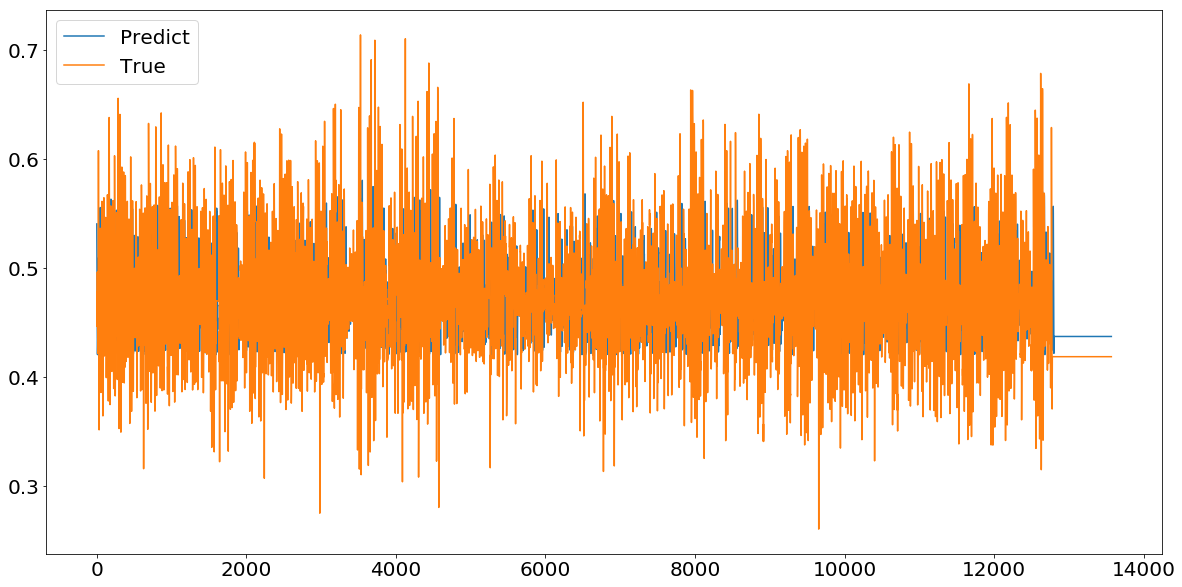

In [69]:
testPredict = model.predict(test_X)
plt.figure(figsize=(20,10))
plt.plot(testPredict, label='Predict')
plt.plot(test_y, label='True')
plt.legend()
plt.rc('font', size=20)

In [70]:
# Train set: rescale
trainPredict = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
ytrain_Predict = np.concatenate((trainPredict, train_X[:, 1:], train_X[:,0].reshape(-1,1)), axis=1)
ytrain_Predict = scaler.inverse_transform(ytrain_Predict)
ytrain_Predict = ytrain_Predict[:,0]
train_y = train_y.reshape((len(train_y), 1))
ytrain = np.concatenate((train_y, train_X[:, 1:], train_X[:,0].reshape(-1,1)), axis=1)
ytrain = scaler.inverse_transform(ytrain)
ytrain = ytrain[:,0]

In [71]:
# Test set: rescale 
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
ytest_Predict = np.concatenate((testPredict, test_X[:, 1:], test_X[:,0].reshape(-1,1)), axis=1)
ytest_Predict = scaler.inverse_transform(ytest_Predict)
ytest_Predict = ytest_Predict[:,0]
test_y = test_y.reshape((len(test_y), 1))
ytest = np.concatenate((test_y, test_X[:, 1:], test_X[:,0].reshape(-1,1)), axis=1)
ytest = scaler.inverse_transform(ytest)
ytest = ytest[:,0]

In [72]:
# Performance Evaluation

In [73]:
rmse = np.sqrt(mean_squared_error(ytrain, ytrain_Predict))
print('Test RMSE: {}'.format(rmse))

Test RMSE: 0.6597264039307795


In [74]:
rmse = np.sqrt(mean_squared_error(ytest, ytest_Predict))
print('Test RMSE: {}'.format(rmse))

Test RMSE: 0.5825933043594919


In [75]:
# Compare with the original data

In [76]:
split = .7
dtrain_size = int(len(all_result0[[all_result0.columns[4]]][1:-25].values)*split)

In [77]:
dtrain = all_result0[[all_result0.columns[4]]][1:-25].values[:dtrain_size,:]
dtest = all_result0[[all_result0.columns[4]]][1:-25].values[dtrain_size:,:]

In [78]:
dtrain_X, dtrain_y = dtrain[:,:-1], dtrain[:,-1]
dtest_X, dtest_y = dtest[:,:-1], dtest[:,-1]

In [79]:
rmse = np.sqrt(mean_squared_error(dtrain_y.reshape(-1,1), ytrain_Predict))
print('Actual Train RMSE: {}'.format(rmse))

Actual Train RMSE: 0.9552041323454694


In [80]:
rmse = np.sqrt(mean_squared_error(dtest_y.reshape(-1,1),ytest_Predict))
print('Actual Test RMSE: {}'.format(rmse))

Actual Test RMSE: 0.7300601583325674
